# Microgrid Location Optimization
This notebook demonstrates how to solve the microgrid location optimization problem using quantum and classical optimization techniques with using DWave and Gurobi. We'll compare the results for both approaches and provide comprehensive visualizations.
    
## Table of Contents
1. Setup and Data Loading
2. Microgrid Location Generation
3. Cost Matrix Construction
4. DWave Quantum Optimization
5. Gurobi Classical Optimization
6. Results Analysis

## 1. Setup and Data Loading

In [17]:
# Required Libraries
import os
import sys
from pathlib import Path
path = str(Path(os.getcwd()))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic
import networkx as nx

# Load the dataset
df = pd.read_csv(path+'/SolarPowerPlants_TH.csv', delimiter=',', skiprows=1)
df

,WKT,Index,latitude,longitude,name,capacity(MW),year PV energy production,Price(0.057/kWh)(USD),Num. Solar panel,Total price
0,POINT (100.1995973 13.5797688),1,13.579769,100.199597,Samut Sakhon,5.0,1408.14,80.26398,10000,802639.800
1,POINT (100.4800113 13.7131258),2,13.713126,100.480011,The Mall - Tha Phra,1.0,1408.99,80.31243,2000,160624.860
2,POINT (100.4474445 13.8199492),3,13.819949,100.447445,Ratchaphruek,1.0,1390.08,79.23456,2000,158469.120
3,POINT (100.5417601 13.8550947),4,13.855095,100.541760,The Mall - Ngamwongwan,1.0,1385.64,78.98148,2000,157962.960
4,POINT (100.6421705 13.7658514),5,13.765851,100.642171,The Mall - Bangkapi,1.0,1385.64,78.98148,2000,157962.960
5,POINT (100.6798205 13.8282182),6,13.828218,100.679821,Akekamai-Ramintra,1.0,1385.15,78.95355,2000,157907.100
6,POINT (101.0033703 13.5759609),7,13.575961,101.003370,Chachoengsao,1.3,1353.26,77.13582,2600,200553.132
7,POINT (100.5528226 14.1690859),8,14.169086,100.552823,Bangchak,16.0,1371.40,78.16980,32000,2501433.600
8,POINT (100.5530586 14.1689819),9,14.168982,100.553059,Bangchak III,25.0,1371.40,78.16980,50000,3908490.000
9,POINT (100.1837652 13.9754302),10,13.975430,100.183765,Sai Thong,6.1,1378.22,78.55854,12200,958414.188


In [18]:
# Extract relevant columns
ind = df['Index']
name = df['name']
lat = df['latitude']
long = df['longitude']
capacity = df['capacity(MW)']
penetration = df['Total price']
locations = {ind: (lat, long) for ind, lat, long in zip(ind, lat, long)}

## 2. Microgrid Location Generation

In [19]:
import scipy.sparse as sp
from networkx.algorithms import community

### create QUBO matrix
# define the distance matrix
num_powerplants = (len(locations.keys())) ## number of solar power plants
pplat, pplong = zip(*locations.values())

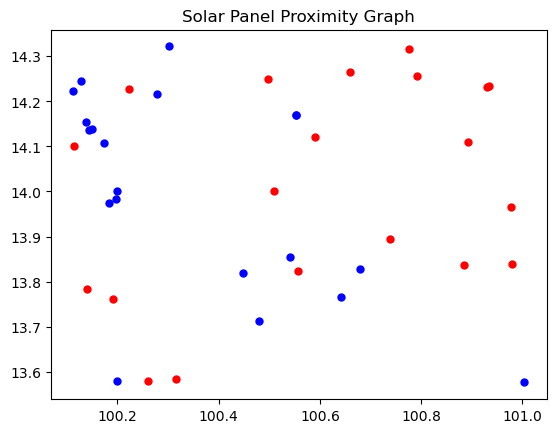

In [20]:
# Generate microgrid locations
num_microgrids = 20 ## number of microgrids
random_lat = np.random.uniform(min(lat), max(lat), size=4*num_microgrids)
lat_choices = np.random.choice(random_lat, size=num_microgrids, replace=False)

random_long = np.random.uniform(min(long), max(long), size=4*num_microgrids)
long_choices = np.random.choice(random_long, size=num_microgrids, replace=False)

# Visualize Graph
fig, ax = plt.subplots()
ax.plot(long, lat, 'o', markersize=5, color='blue')
ax.plot(long_choices, lat_choices, 'o', markersize=5, color='red')
plt.title("Solar Panel Proximity Graph")
plt.show()

## 3. Cost Matrix Construction

In [21]:
def calculate_distance_mgpp(mglat, mglong, pplat, pplong):    
    distance_matrix = np.zeros(len(pplat))
    for i in range(len(pplat)):
        distance_matrix[i] = geodesic((mglat, mglong), (pplat[i], pplong[i])).km
    return distance_matrix

def calculate_distance_mgmg(mglat, mglong):    
    distance_matrix = np.zeros((len(mglat), len(mglat)))
    for i in range(len(mglat)):
        for j in range(len(mglat)):
            if i < j:
                distance_matrix[i][j] = geodesic((mglat[i], mglong[i]), (mglat[j], mglong[j])).km
    return distance_matrix

mgpp_distance = np.zeros(num_microgrids)
for i in range(num_microgrids):
    mgpp_distance[i] = np.sum(calculate_distance_mgpp(lat_choices[i], long_choices[i],pplat, pplong))

mgmg_distance = calculate_distance_mgmg(lat_choices, long_choices)

In [22]:
costCoeff = 10000
mgpp_cost = mgpp_distance * costCoeff
mgmg_cost = mgmg_distance * costCoeff

battery_cost = 38000  # Example fixed cost for battery and inverter installation
solar_cost = 15000  # Example fixed cost for solar panel installation
fixedCost = battery_cost + solar_cost

In [23]:
### QUBO matrix
term1 = (fixedCost*np.ones((1, num_microgrids))) + np.array(penetration) - mgpp_cost
linearTerm = np.zeros((num_microgrids, num_microgrids))
for i in range(num_microgrids):
    linearTerm[i,i] = term1[0,i]
quandTerm = mgmg_cost
qubo_matrix = linearTerm + quandTerm

## 4. DWave Quantum Optimization

In [24]:
from autoqubo import SamplingCompiler, Utils
import timeit

start = timeit.default_timer()

solutions, energy_values = Utils.solve(qubo_matrix)

stop = timeit.default_timer()
print('Time: ', stop - start)

for s, e in zip(solutions, energy_values):
    print(f"x={s}, energy={e}")

ModuleNotFoundError: No module named 'dwave_qbsolv'

## 5. Gurobi Classical Optimization

In [ ]:
from gurobi_optimods.qubo import solve_qubo

start = timeit.default_timer()
 
result = solve_qubo(qubo_matrix)

stop = timeit.default_timer()
print('Time: ', stop - start)

ModuleNotFoundError: No module named 'gurobi_optimods'

## 6. Results Analysis